Kaggle Competition Name:<br>
**Tweet Sentiment Extraction**: https://www.kaggle.com/c/tweet-sentiment-extraction

**Notebook link**: https://www.kaggle.com/ramsahu/simpletransformers-tweet-sentiment-extraction

In [ ]:
#importing the required libraries
import numpy as np
import pandas as pd
from tqdm import tqdm
tqdm.pandas()

import re
import string
import operator
import collections
import itertools
import json

from flashtext import KeywordProcessor

import nltk
en_stop = set(nltk.corpus.stopwords.words('english'))
from nltk.tokenize import word_tokenize

import re
import spacy 
nlp=spacy.load('en_core_web_sm')

import warnings
warnings.filterwarnings('ignore')

from wordcloud import WordCloud, STOPWORDS
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

import fasttext

In [ ]:
## Getting the file path
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/tweet-sentiment-extraction/sample_submission.csv
/kaggle/input/tweet-sentiment-extraction/train.csv
/kaggle/input/tweet-sentiment-extraction/test.csv
/kaggle/input/transformers-pretrained-distilbert/distilbert-base-uncased-distilled-squad/config.json
/kaggle/input/transformers-pretrained-distilbert/distilbert-base-uncased-distilled-squad/tokenizer_config.json
/kaggle/input/transformers-pretrained-distilbert/distilbert-base-uncased-distilled-squad/pytorch_model.bin
/kaggle/input/transformers-pretrained-distilbert/distilbert-base-uncased-distilled-squad/special_tokens_map.json
/kaggle/input/transformers-pretrained-distilbert/distilbert-base-uncased-distilled-squad/vocab.txt


In [ ]:
df_train = pd.read_csv("../input/tweet-sentiment-extraction/train.csv")
df_test = pd.read_csv("../input/tweet-sentiment-extraction/test.csv")
df_sample_submission = pd.read_csv("../input/tweet-sentiment-extraction/sample_submission.csv")

### **EDA and Data Cleaning**

In [ ]:
print("For training data:")
print(df_train["sentiment"].shape)
print(df_train["sentiment"].value_counts())
# print(df_train.describe)
print()
print("For testing data:")
print(df_test["sentiment"].shape)
print(df_test["sentiment"].value_counts())

For training data:
(27481,)
neutral     11118
positive     8582
negative     7781
Name: sentiment, dtype: int64

For testing data:
(3534,)
neutral     1430
positive    1103
negative    1001
Name: sentiment, dtype: int64


### **Missing value imputation**

In [ ]:
df_train["text"]= df_train["text"].str.strip().replace(np.nan, "").str.lower()
df_train["selected_text"]= df_train["selected_text"].str.strip().replace(np.nan, "").str.lower()
df_test["text"]= df_test["text"].str.strip().replace(np.nan, "").str.lower()

In [ ]:
def jaccard(str1, str2): 
    try:
        a = set(str1.split()) 
        b = set(str2.split())
        c = a.intersection(b)
        return float(len(c)) / (len(a) + len(b) - len(c))
    except ZeroDivisionError:
        return 0

df_train["jaccard_scr"] = df_train.progress_apply(lambda x: jaccard(x["text"], x["selected_text"]), axis=1)

100%|██████████| 27481/27481 [00:00<00:00, 30262.28it/s]


In [ ]:
print(df_train["jaccard_scr"].mean())
print(df_train[df_train["sentiment"]=="neutral"]["jaccard_scr"].mean())
print(df_train[df_train["sentiment"]=="positive"]["jaccard_scr"].mean())
print(df_train[df_train["sentiment"]=="negative"]["jaccard_scr"].mean())

0.5890549523414182
0.9763568439593936
0.3143716500527577
0.33861280727421755


In [ ]:
## Text cleaning
text_clean_replace_list = [
    # Special characters
    ['\x89Û_', ''],
    ['\x89ÛÒ', ''],
    ['\x89ÛÓ', ''],
    ['\x89ÛÏWhen', 'When'],
    ['\x89ÛÏ', ''],
    ['China\x89Ûªs', "China's"],
    ['let\x89Ûªs', "let's"],
    ['\x89Û÷', ''],
    ['\x89Ûª', ''],
    ['\x89Û\x9d', ''],
    ['å_', ''],
    ['\x89Û¢', ''],
    ['\x89Û¢åÊ', ''],
    ['fromåÊwounds', 'from wounds'],
    ['åÊ', ''],
    ['åÈ', ''],
    ['JapÌ_n', 'Japan'],
    ['Ì©', 'e'],
    ['å¨', ''],
    ['SuruÌ¤', 'Suruc'],
    ['åÇ', ''],
    ['å£3million', '3 million'],
    ['åÀ', ''],

    # Contractions
    
    ["i`m", 'i am'],
    ["he's", 'he is'],
    ["there's", 'there is'],
    ["We're", 'We are'],
    ["That's", 'That is'],
    ["won't", 'will not'],
    ["they're", 'they are'],
    ["Can't", 'Cannot'],
    ["wasn't", 'was not'],
    ['don\x89Ûªt', 'do not'],
    ["aren't", 'are not'],
    ["isn't", 'is not'],
    ["What's", 'What is'],
    ["haven't", 'have not'],
    ["hasn't", 'has not'],
    ["There's", 'There is'],
    ["He's", 'He is'],
    ["It's", 'It is'],
    ["You're", 'You are'],
    ["I'M", 'I am'],
    ["shouldn't", 'should not'],
    ["wouldn't", 'would not'],
    ["i'm", 'I am'],
    ['I\x89Ûªm', 'I am'],
    ["I'm", 'I am'],
    ["Isn't", 'is not'],
    ["Here's", 'Here is'],
    ["you've", 'you have'],
    ['you\x89Ûªve', 'you have'],
    ["we're", 'we are'],
    ["what's", 'what is'],
    ["couldn't", 'could not'],
    ["we've", 'we have'],
    ['it\x89Ûªs', 'it is'],
    ['doesn\x89Ûªt', 'does not'],
    ['It\x89Ûªs', 'It is'],
    ['Here\x89Ûªs', 'Here is'],
    ["who's", 'who is'],
    ['I\x89Ûªve', 'I have'],
    ["y'all", 'you all'],
    ['can\x89Ûªt', 'cannot'],
    ["would've", 'would have'],
    ["it'll", 'it will'],
    ["we'll", 'we will'],
    ['wouldn\x89Ûªt', 'would not'],
    ["We've", 'We have'],
    ["he'll", 'he will'],
    ["Y'all", 'You all'],
    ["Weren't", 'Were not'],
    ["Didn't", 'Did not'],
    ["they'll", 'they will'],
    ["they'd", 'they would'],
    ["DON'T", 'DO NOT'],
    ['That\x89Ûªs', 'That is'],
    ["they've", 'they have'],
    ["i'd", 'I would'],
    ["should've", 'should have'],
    ['You\x89Ûªre', 'You are'],
    ["where's", 'where is'],
    ['Don\x89Ûªt', 'Do not'],
    ["we'd", 'we would'],
    ["i'll", 'I will'],
    ["weren't", 'were not'],
    ["They're", 'They are'],
    ['Can\x89Ûªt', 'Cannot'],
    ['you\x89Ûªll', 'you will'],
    ['I\x89Ûªd', 'I would'],
    ["let's", 'let us'],
    ["it's", 'it is'],
    ["can't", 'cannot'],
    ["don't", 'do not'],
    ["you're", 'you are'],
    ["i've", 'I have'],
    ["that's", 'that is'],
    ["i'll", 'I will'],
    ["doesn't", 'does not'],
    ["i'd", 'I would'],
    ["didn't", 'did not'],
    ["ain't", 'am not'],
    ["you'll", 'you will'],
    ["I've", 'I have'],
    ["Don't", 'do not'],
    ["I'll", 'I will'],
    ["I'd", 'I would'],
    ["Let's", 'Let us'],
    ["you'd", 'You would'],
    ["It's", 'It is'],
    ["Ain't", 'am not'],
    ["Haven't", 'Have not'],
    ["Could've", 'Could have'],
    ['youve', 'you have'],
    ['donå«t', 'do not'],

    # Character entity references
    ['&gt;', '>'],
    ['&lt;', '<'],
    ['&amp;', '&'],

    # Typos', 'slang and informal abbreviations
    ['w/e', 'whatever'],
    ['w/', 'with'],
    ['USAgov', 'USA government'],
    ['recentlu', 'recently'],
    ['Ph0tos', 'Photos'],
    ['amirite', 'am I right'],
    ['exp0sed', 'exposed'],
    ['<3', 'love'],
    ['lmao', 'laughing my ass off'],
    ['thankU', 'thank you'],

    # Acronyms
    ['MH370', 'Malaysia Airlines Flight 370'],
    ['mÌ¼sica', 'music'],
    ['okwx', 'Oklahoma City Weather'],
    ['arwx', 'Arkansas Weather'],
    ['gawx', 'Georgia Weather'],
    ['scwx', 'South Carolina Weather'],
    ['cawx', 'California Weather'],
    ['tnwx', 'Tennessee Weather'],
    ['azwx', 'Arizona Weather'],
    ['alwx', 'Alabama Weather'],
    ['wordpressdotcom', 'wordpress'],
    ['usNWSgov', 'United States National Weather Service'],
    ['Suruc', 'Sanliurfa'],

    # Grouping same words without embeddings
    ['Bestnaijamade', 'bestnaijamade'],
    ['SOUDELOR', 'Soudelor'],
]

## Replace using flashtext instead of regex as it is many folds faster in text search and text replace

kp_replace_clean = KeywordProcessor()
for elem in text_clean_replace_list:
    kp_replace_clean.add_keyword(elem[0].strip(), elem[1].strip())
test__ ="Hi this is don't testing on http://www.kaggle.com/rtatman/import-functions-from-kaggle-script and not this"

def clean(string):
    kp_replace_clean.replace_keywords(string)
    return re.sub(r"https?:[^\s]*", "website", string, re.I)
    
clean(test__)

"Hi this is don't testing on website and not this"

In [ ]:
## Cleaning the text columns
df_train["text"]=df_train["text"].progress_apply(lambda x: clean(x))
df_train["selected_text"]=df_train["selected_text"].progress_apply(lambda x: clean(x))
df_test["text"]=df_test["text"].progress_apply(lambda x: clean(x))

100%|██████████| 3534/3534 [00:00<00:00, 25739.97it/s]


In [ ]:
df_train["text_tok"]=df_train["text"].progress_apply(lambda x: [elem.orth_ for elem in nlp(x)])
df_train["len_text_tok"]=df_train["text_tok"].progress_apply(lambda x: len(x))

df_train["selected_text_tok"]=df_train["selected_text"].progress_apply(lambda x: [elem.orth_ for elem in nlp(x)])
df_train["len_selected_text_tok"]=df_train["selected_text_tok"].progress_apply(lambda x: len(x))

df_test["text_tok"]=df_test["text"].progress_apply(lambda x: [elem.orth_ for elem in nlp(x)])
df_test["len_text_tok"]=df_test["text_tok"].progress_apply(lambda x: len(x))

100%|██████████| 3534/3534 [00:00<00:00, 478923.11it/s]


In [ ]:
df_train = df_train[df_train["len_text_tok"]>0]
df_train.reset_index(drop=True, inplace=True)

In [ ]:
df_train.groupby("sentiment").mean()["jaccard_scr"]

sentiment
negative    0.338613
neutral     0.976445
positive    0.314372
Name: jaccard_scr, dtype: float64

### **EDA**

In [ ]:
## Remove stopwords just for EDA 
en_stop_new=list(string.punctuation)
en_stop = list(en_stop) + en_stop_new

def freq_analysis_df(df, col, top_freq=False):
    temp_text = ' '.join(df[col])
    wordcloud2 = WordCloud().generate(temp_text)
    plt.imshow(wordcloud2)
    plt.axis("off")
    plt.show()
    sns.distplot(df["len_"+col+"_tok"])
        
    temp_flat = [item.lower().strip() for sublist in df[col+"_tok"] for item in sublist if item.lower() not in en_stop]
    if top_freq!=False:
        temp = pd.DataFrame(collections.Counter(temp_flat).most_common(top_freq), columns = ['Common_words','count'])
        display(temp.style.background_gradient(cmap='Blues'))

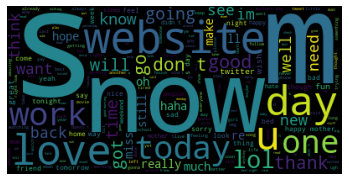

,Common_words,count
0,,10357
1,...,3873
2,i`m,2244
3,day,2096
4,..,1668
5,good,1573
6,get,1430
7,like,1353
8,go,1281
9,website,1270


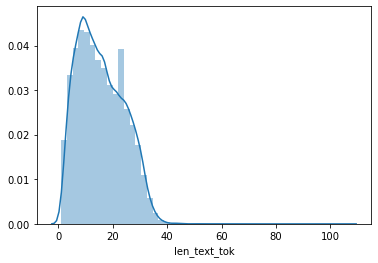

In [ ]:
freq_analysis_df(df_train, "text", 30)

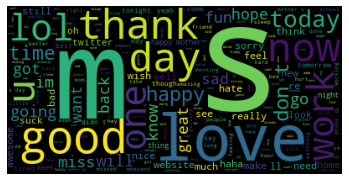

,Common_words,count
0,,4598
1,...,1768
2,good,1256
3,i`m,1224
4,day,1087
5,..,1056
6,love,912
7,happy,855
8,get,776
9,like,774


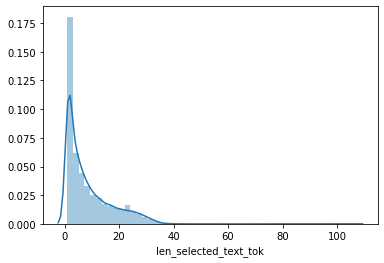

In [ ]:
freq_analysis_df(df_train, "selected_text", 50)

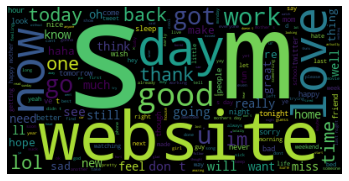

,Common_words,count
0,,1303
1,...,468
2,i`m,279
3,day,233
4,..,222
5,good,211
6,website,183
7,it`s,176
8,got,169
9,like,166


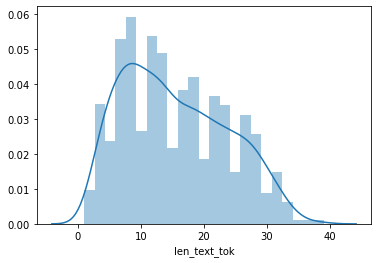

In [ ]:
freq_analysis_df(df_test, "text", 50)

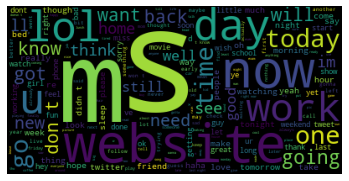

,Common_words,count
0,,3869
1,...,1459
2,i`m,771
3,..,638
4,get,627
5,website,601
6,go,583
7,got,532
8,day,520
9,lol,493


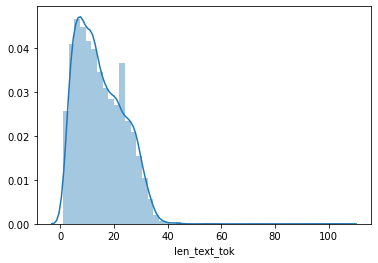

In [ ]:
freq_analysis_df(df_train[df_train["sentiment"]=="neutral"], "text", 50)

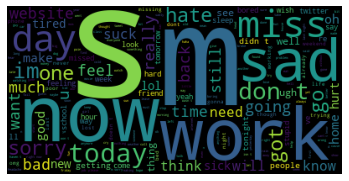

,Common_words,count
0,,2833
1,...,1299
2,i`m,902
3,..,519
4,like,478
5,nt,457
6,get,435
7,miss,425
8,go,403
9,work,399


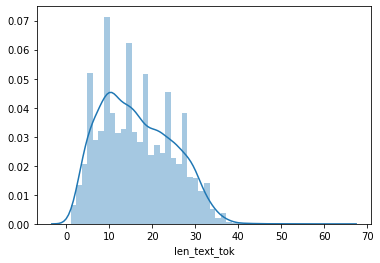

In [ ]:
freq_analysis_df(df_train[df_train["sentiment"]=="negative"], "text", 50)

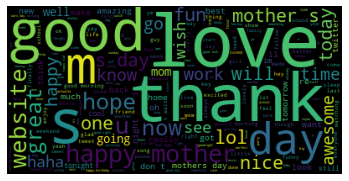

,Common_words,count
0,,3655
1,day,1248
2,...,1115
3,good,1063
4,love,885
5,happy,857
6,i`m,571
7,thanks,563
8,..,511
9,great,481


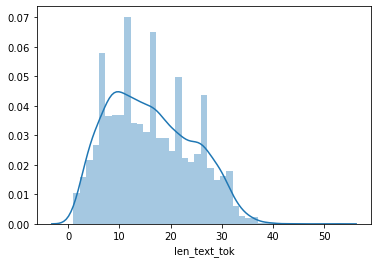

In [ ]:
freq_analysis_df(df_train[df_train["sentiment"]=="positive"], "text", 50)

In [ ]:
## Getting unique/non-overlapping words in each of the category

positive_text_list = df_train[df_train["sentiment"]=="positive"]["text_tok"]
positive_text_list = [item for sublist in positive_text_list for item in sublist]
negative_text_list = df_train[df_train["sentiment"]=="negative"]["text_tok"]
negative_text_list = [item for sublist in negative_text_list for item in sublist]
neutral_text_list = df_train[df_train["sentiment"]=="neutral"]["text_tok"]
neutral_text_list = [item for sublist in neutral_text_list for item in sublist]


positive_sel_text_list = df_train[df_train["sentiment"]=="positive"]["selected_text_tok"]
positive_sel_text_list = [item for sublist in positive_sel_text_list for item in sublist]
negative_sel_text_list = df_train[df_train["sentiment"]=="negative"]["selected_text_tok"]
negative_sel_text_list = [item for sublist in negative_sel_text_list for item in sublist]
neutral_sel_text_list = df_train[df_train["sentiment"]=="neutral"]["selected_text_tok"]
neutral_sel_text_list = [item for sublist in neutral_sel_text_list for item in sublist]


temp_pos_neg_text = list(set(positive_text_list + negative_text_list))
temp_neut_neg_text = list(set(neutral_text_list + negative_text_list))
temp_neut_pos_text = list(set(neutral_text_list + positive_text_list))

temp_pos_neg_sel_text = list(set(positive_sel_text_list + negative_sel_text_list))
temp_neut_neg_sel_text = list(set(neutral_sel_text_list + negative_sel_text_list))
temp_neut_pos_sel_text = list(set(neutral_sel_text_list + positive_sel_text_list))

### Unique words in each of the categories in the "text" column
unique_positive_text_list = [elem for elem in positive_text_list if elem not in (temp_neut_neg_text)]
unique_negative_text_list = [elem for elem in negative_text_list if elem not in (temp_neut_pos_text)]
unique_neutral_text_list = [elem for elem in neutral_text_list if elem not in (temp_pos_neg_text)]

### Unique words in each of the categories in the "selected_text" column
unique_positive_text_sel_text_list = [elem for elem in positive_sel_text_list if elem not in (temp_neut_neg_sel_text)]
unique_negative_text_sel_text_list = [elem for elem in negative_sel_text_list if elem not in (temp_neut_pos_sel_text)]
unique_neutral_text_sel_text_list = [elem for elem in neutral_sel_text_list if elem not in (temp_pos_neg_sel_text)]

In [ ]:
## Remove stopwords just for EDA 
# en_stop_new=list(string.punctuation)
# en_stop = list(en_stop) + en_stop_new

def freq_analysis_list(list_, top_freq=False):
    temp_text = ' '.join(list_)
    wordcloud2 = WordCloud().generate(temp_text)
    plt.imshow(wordcloud2)
    plt.axis("off")
    plt.show()

    if top_freq!=False:
        temp = pd.DataFrame(collections.Counter(list_).most_common(top_freq), columns = ['Common_words','count'])
        display(temp.style.background_gradient(cmap='Blues'))

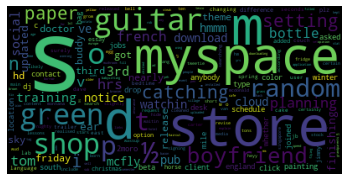

,Common_words,count
0,store,28
1,guitar,26
2,green,22
3,how`s,22
4,myspace,17
5,boyfriend,17
6,catching,16
7,shop,16
8,planning,15
9,random,15


In [ ]:
freq_analysis_list(unique_neutral_text_sel_text_list, 30)

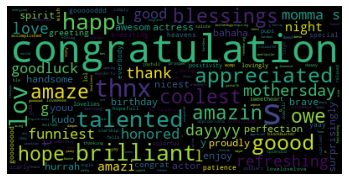

,Common_words,count
0,congratulations,24
1,thnx,8
2,lov,8
3,happ,7
4,talented,7
5,brilliant,7
6,appreciated,6
7,goood,6
8,blessings,5
9,amazin,5


In [ ]:
freq_analysis_list(unique_positive_text_sel_text_list, 30)

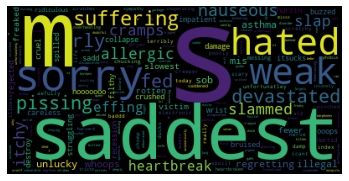

,Common_words,count
0,saddest,7
1,.i`m,6
2,hated,6
3,weak,6
4,suffering,6
5,.sorry,5
6,rly,5
7,devastated,5
8,pissing,5
9,nauseous,4


In [ ]:
freq_analysis_list(unique_negative_text_sel_text_list, 30)

## **Solving it as a Question and Answer problem:**

In [ ]:
# Adpated from https://www.kaggle.com/jonathanbesomi/question-answering-starter-pack

In [ ]:
# # Prepare data in QA format
# # Example-format: Training Data

# one_train_data = {
#     'context': "This tweet sentiment extraction challenge is great",
#     'qas': [
#         {
#             'id': "00001",
#             'question': "positive",
#             'answers': [
#                 {
#                     'text': "is great",
#                     'answer_start': 43
#                 }
#             ]
#         }
#     ]
# }


# # Example-format: Testing Data

# one_test_data = {
#     'context': 'last session of the day  website',
#     'qas': [
#         {'question': 'neutral',
#          'id': 'f87dea47db',
#          'is_impossible': False,
#          'answers': [
#              {
#                  'answer_start': 1000000,
#                  'text': '__None__'
#              }
#          ]
#         }
#     ]
# }

In [ ]:
def data_in_qa_format(df_row, data_type):
    if data_type=="train":
        answer_start = df_row["text"].find(df_row["selected_text"])
        selected_text = df_row["selected_text"]
    else:
        answer_start=1000000
        selected_text = "__None__"

    if type(df_row["text"])!=str:
        df_row["text"]=""
    if type(df_row["sentiment"])!=str:
        df_row["sentiment"]=""

    return {
        'context': df_row["text"],
        'qas': [{'id': df_row["textID"],
                 'question': df_row["sentiment"],
                 'answers': [{'text': selected_text,
                              'answer_start': answer_start
                             }
                            ]
                }
               ]
    }
nu=2
display(data_in_qa_format(df_train.iloc[nu], "train"))
display(data_in_qa_format(df_train.iloc[nu], "test"))

{'context': 'my boss is bullying me...',
 'qas': [{'id': '088c60f138',
   'question': 'negative',
   'answers': [{'text': 'bullying me', 'answer_start': 11}]}]}

{'context': 'my boss is bullying me...',
 'qas': [{'id': '088c60f138',
   'question': 'negative',
   'answers': [{'text': '__None__', 'answer_start': 1000000}]}]}

In [ ]:
df_train["train_dic"] = df_train.progress_apply(lambda x: data_in_qa_format(x, "train"), axis=1)
df_test["test_dic"] = df_test.progress_apply(lambda x: data_in_qa_format(x, "test"), axis=1)

100%|██████████| 3534/3534 [00:00<00:00, 11660.58it/s]


In [ ]:
df_train["train_dic"].tolist()[2:4]

[{'context': 'my boss is bullying me...',
  'qas': [{'id': '088c60f138',
    'question': 'negative',
    'answers': [{'text': 'bullying me', 'answer_start': 11}]}]},
 {'context': 'what interview! leave me alone',
  'qas': [{'id': '9642c003ef',
    'question': 'negative',
    'answers': [{'text': 'leave me alone', 'answer_start': 16}]}]}]

In [ ]:
df_test["test_dic"].tolist()[2:4]

[{'context': 'recession hit veronique branquinho, she has to quit her company, such a shame!',
  'qas': [{'id': 'eee518ae67',
    'question': 'negative',
    'answers': [{'text': '__None__', 'answer_start': 1000000}]}]},
 {'context': 'happy bday!',
  'qas': [{'id': '01082688c6',
    'question': 'positive',
    'answers': [{'text': '__None__', 'answer_start': 1000000}]}]}]

In [ ]:
with open('train.json', 'w') as outfile:
    json.dump(df_train["train_dic"].tolist(), outfile)

with open('test.json', 'w') as outfile:
    json.dump(df_test["test_dic"].tolist(), outfile)    

In [ ]:
## Install simple-transformers, a tool to train and test transformers model easily.

!pip install simpletransformers

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [ ]:
import gc
gc.collect()

190

In [ ]:
# Train the distilbert-base-uncased-distilled-squad model
use_cuda = True # whether to use GPU or not

from simpletransformers.question_answering import QuestionAnsweringModel

MODEL_PATH = '/kaggle/input/transformers-pretrained-distilbert/distilbert-base-uncased-distilled-squad/'

# Create the QuestionAnsweringModel
model = QuestionAnsweringModel('distilbert', 
                               MODEL_PATH, 
                               args={'reprocess_input_data': True,
                                     'overwrite_output_dir': True,
                                     'learning_rate': 5e-5,
                                     'num_train_epochs': 3,
                                     'max_seq_length': 192,
                                     'doc_stride': 64,
                                     'fp16': False,
                                    },
                              use_cuda=use_cuda)

model.train_model('train.json')

Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at /kaggle/input/transformers-pretrained-distilbert/distilbert-base-uncased-distilled-squad/ and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
convert squad examples to features:   0%|          | 0/27480 [00:00<?, ?it/s]Could not find answer: '' vs. '. he gives twitter tips. hope this helps'
Could not find answer: '' vs. '4 i just noticed that too'
Could not find answer: '' vs. 'aam these dogs are going to die if somebody doesn`t save them!'
Could not find answer: '' vs. '. i still can`t believe they won`t renew tscc'
convert squad examples to features:   0%|          | 1/27480 [00:33<253:45:31, 33.24s/it]Could not find answer: '' vs. 'd stinks'
Could not find answer: '' vs. 'wave looks interesting. ht'
Could not find answer: 'website' vs. 'does anyone out there want

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/3435 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/3435 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/3435 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
predictions = model.predict(df_test["test_dic"].tolist())
predictions_df = pd.DataFrame.from_dict(predictions[0])
df_test['selected_text'] = predictions_df['answer'].progress_apply(lambda x:x[0])
df_test[["textID", "selected_text"]].to_csv('submission.csv', index=False)
df_test.head()

Following is to be done:
- Improve/Finetune this model
- Try different methods and models

Thanks for your time<br />
## **ッ**